<div>
    <h2> Network Intrusion Detection using Linear Models, GBDT Ensembles and Deep Learning - A comparative study using state-of-the-art tools and libraries </h2>
    <p> In this study, we use the <a href='https://www.unb.ca/cic/datasets/nsl.html'>NSL KDD dataset</a> to predict the probability of occurence of 23 different classes of attacks on a network. Here, we use three different categories of models - Linear Models including Logistic Regression and Stochastic Gradient Descent (SGD) classifier; Gradient Boosting Decision Tree emsembles including LightGBM (LGBM) and XGBoost; and a Deep Neural Network (DNN) classifier. We also train a stacked model consisting of all these models as base learners. Finally, we compare the performances of all the models for Network Intrusion Detection using the NSL-KDD dataset and draw useful conclusions.</p>
</div>

In [41]:
# import required packages

import pandas as pd 
import numpy as np
import math, os, re, gc, time, warnings
from tqdm import tqdm

from entropy_calculator import ddosDetection
from scapy.all import *
import time

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



%matplotlib inline

# settings
os.environ['OMP_NUM_THREADS'] = '4'
start_time = time.time()


warnings.filterwarnings("ignore")

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

In [2]:
'''
# 다음과 같은 정규화 식으로 출력하기에는 너무 오래 걸려서 이부분은 파이참 코드로 따로 돌림

import pandas as pd
import numpy as np
import math, os, re, gc, time, warnings
from tqdm import tqdm


start_time = time.time()
warnings.filterwarnings("ignore")
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)



data = pd.read_csv('god.csv')


idx_nm=data[((data['Protocol']=='TCP') | (data['Protocol']=='UDP') | (data['Protocol']=='ICMP'))].index #or'TCP'or'UDP'
data= data.loc[idx_nm]

data['Source Port']=np.nan
data['Destination Port']=np.nan

m=re.compile(r'[0-9]{0,6}\s{2}>\s{2}[0-9]{0,6}')

#for i in tqdm(range(100)):
for i in tqdm(range(data.shape[0])):
    port_labelging_1=re.findall("[0-9]{0,6}\s{2}>\s{2}[0-9]{0,6}", data.iloc[i]['Info'])
    port_labelging_2=''.join(port_labelging_1)
    port_labelging_3=port_labelging_2.split('  ')
    #print(port_labelging_3[0], port_labelging_3[-1])
    #data.loc[i, 'Source Port']=port_labelging_3[0]
    #data.loc[i, 'Destination Port']=port_labelging_3[-1]
    data.iloc[i, 7]=port_labelging_3[0]
    data.iloc[i, 8]=port_labelging_3[-1]



#data2=data.loc[:100]
#data2.to_csv('god2.csv', index=False)
data.to_csv('god2.csv', index=False)

'''

'\n# 다음과 같은 정규화 식으로 출력하기에는 너무 오래 걸려서 이부분은 파이참 코드로 따로 돌림\n\nimport pandas as pd\nimport numpy as np\nimport math, os, re, gc, time, warnings\nfrom tqdm import tqdm\n\n\nstart_time = time.time()\nwarnings.filterwarnings("ignore")\npd.set_option(\'display.max_row\', 100)\npd.set_option(\'display.max_columns\', 100)\n\n\n\ndata = pd.read_csv(\'god.csv\')\n\n\nidx_nm=data[((data[\'Protocol\']==\'TCP\') | (data[\'Protocol\']==\'UDP\') | (data[\'Protocol\']==\'ICMP\'))].index #or\'TCP\'or\'UDP\'\ndata= data.loc[idx_nm]\n\ndata[\'Source Port\']=np.nan\ndata[\'Destination Port\']=np.nan\n\nm=re.compile(r\'[0-9]{0,6}\\s{2}>\\s{2}[0-9]{0,6}\')\n\n#for i in tqdm(range(100)):\nfor i in tqdm(range(data.shape[0])):\n    port_labelging_1=re.findall("[0-9]{0,6}\\s{2}>\\s{2}[0-9]{0,6}", data.iloc[i][\'Info\'])\n    port_labelging_2=\'\'.join(port_labelging_1)\n    port_labelging_3=port_labelging_2.split(\'  \')\n    #print(port_labelging_3[0], port_labelging_3[-1])\n    #data.loc[i, \'Source Port\']=por

In [3]:
#특정 프로토콜만 남기고, info에서 Source Port, Destination Port  추출하고 2번째로 저장
#data.to_csv('god2.csv',index=False)
#data = pd.read_csv('god2.csv')

In [4]:
data.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info,Source Port,Destination Port
0,49,0.197691,192.168.10.14,40.83.143.209,TCP,60,49461 > 443 [ACK] Seq=1 Ack=870 Win=258 Len=0,49461.0,443.0
1,74,0.364188,192.168.10.14,40.83.143.209,TCP,1494,49460 > 443 [ACK] Seq=278 Ack=1 Win=258 Len=...,49460.0,443.0
2,88,0.450603,40.83.143.209,192.168.10.14,TCP,60,443 > 49460 [ACK] Seq=1 Ack=1718 Win=513 Len=0,443.0,49460.0
3,89,0.450863,40.83.143.209,192.168.10.14,TCP,60,443 > 49460 [ACK] Seq=1 Ack=3915 Win=513 Len=0,443.0,49460.0
4,205,0.908536,192.168.10.14,40.83.143.209,TCP,60,49460 > 443 [ACK] Seq=3915 Ack=310 Win=257 L...,49460.0,443.0
5,248,1.024147,192.168.10.14,40.83.143.209,TCP,1494,49461 > 443 [ACK] Seq=278 Ack=870 Win=258 Le...,49461.0,443.0
6,272,1.110482,40.83.143.209,192.168.10.14,TCP,60,443 > 49461 [ACK] Seq=870 Ack=1718 Win=513 L...,443.0,49461.0
7,273,1.110848,40.83.143.209,192.168.10.14,TCP,60,443 > 49461 [ACK] Seq=870 Ack=3883 Win=513 L...,443.0,49461.0
8,320,1.477442,192.168.10.14,40.83.143.209,TCP,60,49461 > 443 [ACK] Seq=3883 Ack=1739 Win=255 ...,49461.0,443.0
9,322,1.519729,192.168.10.12,192.168.10.3,TCP,466,"[TCP Retransmission] 59656 > 3268 [PSH, ACK]...",59656.0,3268.0


In [5]:
data["len_Separation_128"] = np.nan
#구간 목록 만들기 
len_Separation_128 =list(range(0,65537,128))
#구간별 라벨링 이름 만들기
len_Separation_128_label = [str(x)+" ~ "+str(x+128) for x in len_Separation_128]
#데이터 길이별 라벨링
data["len_Separation_128"] = pd.cut(data["Length"], len_Separation_128, right=False, labels=len_Separation_128_label[:-1])

In [6]:
#2에서 데이터 길이별 라벨링해서 저장
#data.to_csv('god3.csv',index=False)

In [7]:
data=data[['Time', 'Source','Destination','Protocol','Source Port','Destination Port', 'len_Separation_128']]
data.rename(columns={'Source':'Source IP', 'Destination':'Destination IP'})

,Time,Source IP,Destination IP,Protocol,Source Port,Destination Port,len_Separation_128
0,0.197691,192.168.10.14,40.83.143.209,TCP,49461.0,443.0,0 ~ 128
1,0.364188,192.168.10.14,40.83.143.209,TCP,49460.0,443.0,1408 ~ 1536
2,0.450603,40.83.143.209,192.168.10.14,TCP,443.0,49460.0,0 ~ 128
3,0.450863,40.83.143.209,192.168.10.14,TCP,443.0,49460.0,0 ~ 128
4,0.908536,192.168.10.14,40.83.143.209,TCP,49460.0,443.0,0 ~ 128
...,...,...,...,...,...,...,...
11248688,30452.476199,192.168.10.14,192.168.10.3,TCP,58669.0,445.0,128 ~ 256
11248689,30452.476248,192.168.10.3,192.168.10.14,TCP,445.0,58669.0,384 ~ 512
11248690,30452.476299,192.168.10.3,192.168.10.14,TCP,445.0,58669.0,256 ~ 384
11248691,30452.476386,192.168.10.14,192.168.10.3,TCP,58669.0,445.0,0 ~ 128


In [99]:
#3에서 실험에 쓸 자료만 남기고 다시 저장
#data.to_csv('god4.csv',index=False)
data = pd.read_csv('god4.csv')

In [100]:
#기존 오브제특 형태인 ip address 를 제거, 나머지 데이터 라벨 인코더
encoder = LabelEncoder()

# 기존 포트 번호를 라벨링으로 생성
en_col=['Source Port' , 'Destination Port', 'Protocol','Source IP', 'Destination IP', 'len_Separation_128']
for i in en_col:
    data[i] = encoder.fit_transform(data[i])
    

In [101]:
data=data[:100000]

In [106]:
entropy_SP_store=[]
entropy_DP_store=[]
entropy_SIP_store=[]
entropy_DIP_store=[]
entropy_LEN_store=[]

for i in tqdm(range(0,len(data),100)):
    ds=data.loc[i:i+100]

    unique_SP=ds['Source Port'].unique()
    unique_DP=ds['Destination Port'].unique()   
    unique_SIP=ds['Source IP'].unique()
    unique_DIP=ds['Destination IP'].unique()
    unique_LEN=ds['len_Separation_128'].unique()    


    entropy_SP = []
    for j in unique_SP:
        un_j = len(ds[ds['Source Port']==j])/len(ds)
        entropy_SP.append(-un_j * math.log2(un_j))
        

    entropy_DP = []
    for j in unique_DP:
        un_j = len(ds[ds['Destination Port']==j])/len(ds)
        entropy_DP.append(-un_j * math.log2(un_j))
    
    entropy_SIP = []
    for j in unique_SIP:
        un_j = len(ds[ds['Source IP']==j])/len(ds)
        entropy_SIP.append(-un_j * math.log2(un_j))
        

    entropy_DIP = []
    for j in unique_DIP:
        un_j = len(ds[ds['Destination IP']==j])/len(ds)
        entropy_DIP.append(-un_j * math.log2(un_j))
        
        

    entropy_LEN = []
    for j in unique_LEN:
        un_j = len(ds[ds['len_Separation_128']==j])/len(ds)
        entropy_LEN.append(-un_j * math.log2(un_j))

    entropy_LEN_store.append(sum(entropy_LEN)) 
    entropy_SIP_store.append(sum(entropy_SIP))
    entropy_DIP_store.append(sum(entropy_DIP)) 
    entropy_SP_store.append(sum(entropy_SP))
    entropy_DP_store.append(sum(entropy_DP))   
   #print(i,"번째",sum(entropy_SP),sum(entropy_DP))  

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.91it/s]


In [ ]:
de_ip = ddosDetection()
so_ip = ddosDetection()
de_port = ddosDetection()
so_port = ddosDetection()
len=ddosDetection()

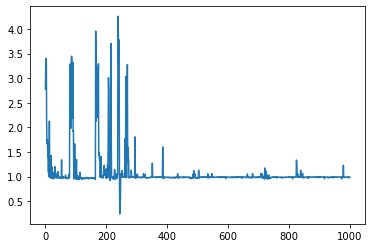

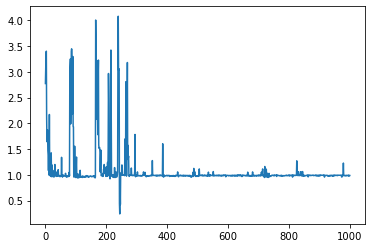

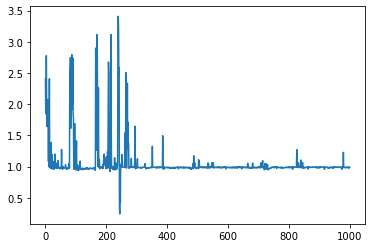

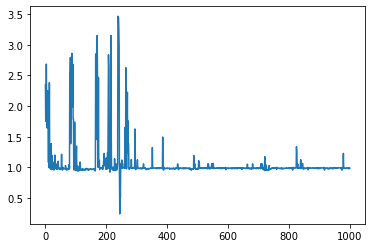

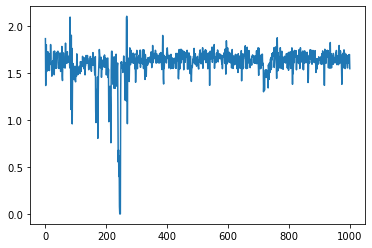

In [107]:
plt.plot(entropy_SP_store)
plt.show()

plt.plot(entropy_DP_store)
plt.show()

plt.plot(entropy_SIP_store)
plt.show()

plt.plot(entropy_DIP_store)
plt.show()

plt.plot(entropy_LEN_store)
plt.show()

In [ ]:
def ids(a,b,c)
    if <a<
    
    
def entropy_average(a,b,c)
    a